In [1]:
from hashlib import md5
from pathlib import Path
import pandas as pd
import numpy as np
from tqdm.auto import tqdm
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.decomposition import PCA

In [2]:
def file_hash(x, note=""):
    h = md5()
    h.update(Path(x).read_bytes())
    print(x, h.hexdigest()[:6], note, sep="\t")

## Data dependencies
```
./data/merge_df.pkl	3edd8f	
```

In [3]:
# all_data.csv might be different
file_hash("./data/merge_df.pkl")

./data/merge_df.pkl	3edd8f	


In [4]:
merge_df = pd.read_pickle('./data/merge_df.pkl')
all_tsne_df = pd.read_pickle('./data/all_tsne_df.pkl')

In [5]:
merge_df.columns

Index(['transcription', 'role', 'meaning', 'speaker', 't_start', 't_end',
       'freq_f1', 'freq_f2', 'freq_f3', 'a1p0', 'point_time', 'point_pct',
       'filename', 'offset_id', 'offset_s', 'bilstm', 'phone', 'person'],
      dtype='object')

In [6]:
merge_df.iloc[:,:13].to_csv("data/rolemean_acoustic.csv", index=False)

## Vowel acoustic points

In [7]:
# selected_phones = "[aeioɤəu]"
# vdata = merge_df.loc[merge_df.phone.str.contains(selected_phones), :]
vdata = merge_df

bilstm = np.vstack(vdata.bilstm)

reducer = PCA()
bilstm_pca = reducer.fit_transform(bilstm)


In [8]:
vdata.shape, bilstm_pca.shape

((1170, 18), (1170, 640))

first 20 0.69014865
first 50 0.81513625


<BarContainer object of 50 artists>

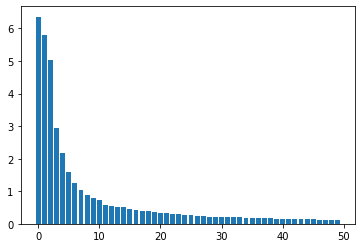

In [15]:
print("first 20", reducer.explained_variance_[:20].sum() / reducer.explained_variance_.sum())
print("first 50", reducer.explained_variance_[:50].sum() / reducer.explained_variance_.sum())
plt.bar(x=np.arange(50), height=reducer.explained_variance_[:50])

## Eyeballing TSNE

In [16]:
from sklearn.manifold import TSNE
tsne_reducer = TSNE(2, learning_rate=1e-3, init="pca", perplexity=50, random_state=1234)
bilstm_tsne = tsne_reducer.fit_transform(bilstm_pca[:,:50])

C:\Python310\lib\site-packages\sklearn\manifold\_t_sne.py:991: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


<AxesSubplot:>

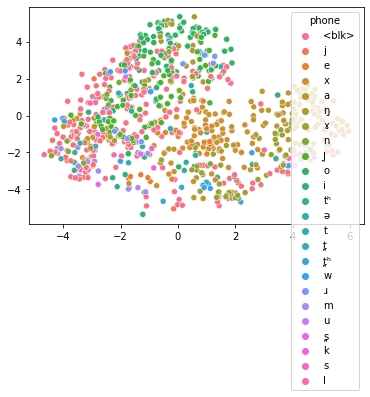

In [17]:
import seaborn as sns
sns.scatterplot(x=bilstm_tsne[:,0], y=bilstm_tsne[:,1], hue=vdata.phone)

## Write CSV

In [18]:
bilstm_df = pd.DataFrame(bilstm_pca[:,:10], index=vdata.index)
bilstm_df.columns = [f"bpc_{x:02d}" for x in range(10)]
tsne_df = pd.DataFrame(bilstm_tsne, index=vdata.index)
tsne_df.columns = [f"tsne_{x}" for x in range(2)]
concat_data = pd.concat([vdata, tsne_df, bilstm_df], axis=1)
concat_data

,transcription,role,meaning,speaker,t_start,t_end,freq_f1,freq_f2,freq_f3,a1p0,...,bpc_00,bpc_01,bpc_02,bpc_03,bpc_04,bpc_05,bpc_06,bpc_07,bpc_08,bpc_09
0,he,filler,neutral,A,7.761102,8.006046,818,1923,2689,-8.36,...,-0.042021,-4.468820,-0.159695,-0.440740,0.992692,0.109931,0.273855,-0.037211,0.527473,2.101352
1,he,filler,neutral,A,7.761102,8.006046,818,2032,2914,-2.85,...,-2.846055,-2.200657,-1.016560,-0.310892,1.360016,0.694960,-1.541938,-1.052383,-0.305156,1.505386
2,he,filler,neutral,A,7.761102,8.006046,754,2045,3070,-3.75,...,-2.846058,-2.200657,-1.016559,-0.310893,1.360015,0.694955,-1.541938,-1.052383,-0.305155,1.505388
3,he,filler,neutral,A,7.761102,8.006046,366,1960,3185,5.78,...,-3.148462,-2.408315,-0.234465,0.109784,1.559404,0.923316,0.034145,-1.005814,-0.501402,1.059329
4,he,filler,neutral,A,7.761102,8.006046,215,1966,3736,0.00,...,-3.289527,-3.468075,2.699620,-0.236097,1.426521,0.666839,-0.569649,1.326675,-1.013675,-0.416427
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1165,ho,filler,neutral,B,451.414511,451.530224,711,1215,2722,-4.80,...,2.581040,-2.644088,1.760493,-2.878297,1.128210,2.002235,-0.377271,-1.190551,0.869787,-0.086232
1166,ho,filler,neutral,B,451.414511,451.530224,301,1032,2413,-0.03,...,2.581040,-2.644088,1.760493,-2.878297,1.128210,2.002235,-0.377271,-1.190551,0.869787,-0.086232
1167,ho,filler,neutral,B,451.414511,451.530224,258,1218,3283,-2.63,...,-1.586577,1.055678,1.035436,-2.747242,0.405882,1.576339,0.532100,1.657935,1.571102,-0.086231
1168,ho,filler,neutral,B,451.414511,451.530224,431,1746,3091,-17.14,...,-1.586577,1.055678,1.035436,-2.747242,0.405882,1.576339,0.532100,1.657935,1.571102,-0.086231


```
0   -4.550011
1   -2.211336
2   -2.211446
3   -2.284600
4   -3.341223
Name: tsne_1, dtype: float32
```

In [20]:
concat_data.tsne_1.head()

0   -4.550011
1   -2.211336
2   -2.211446
3   -2.284600
4   -3.341223
Name: tsne_1, dtype: float32

The hash is not reproducible. The TSNE produce slightly different results every time.
```
data/rolemean_pca20.csv	e209e3	
```

In [21]:
concat_data.to_csv("data/rolemean_pca20.csv", index=False)
file_hash("data/rolemean_pca20.csv")

data/rolemean_pca20.csv	e209e3	
